# Exploratory Data Analysis (EDA) on the downloaded and cleaned data

## 1. Libraries import and variables definition

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

## 2. Load the data

In [2]:
assets    = pd.read_feather('./src_zip/assets.ftr')
cand      = pd.read_feather('./src_zip/cand.ftr')
hired     = pd.read_feather('./src_zip/hired_ex.ftr')
sett      = pd.read_feather('./src_zip/settl_ex.ftr')
rev       = pd.read_feather('./src_zip/revenue.ftr')
other_rev = pd.read_feather('./src_zip/other_rev.ftr')

## 3. Analysis on the candidates owned assets

In [3]:
# data not grouped by candidate id
# describe values in thousands
(assets['VR_BEM_CANDIDATO'] / 1000).describe() 

count      93271.000000
mean         257.291394
std         6875.363075
min            0.000000
25%            8.301735
50%           37.000000
75%          122.033685
max      1000000.000000
Name: VR_BEM_CANDIDATO, dtype: float64

In [4]:
# group by candidate id
total_assets_by_cand = assets.groupby(['SQ_CANDIDATO']).sum().sort_values(by='VR_BEM_CANDIDATO', ascending=False)
(total_assets_by_cand['VR_BEM_CANDIDATO'] / 1000).describe()

count    1.761400e+04
mean     1.362429e+03
std      1.920877e+04
min      0.000000e+00
25%      6.000000e+01
50%      2.274984e+02
75%      6.500000e+02
max      1.202007e+06
Name: VR_BEM_CANDIDATO, dtype: float64

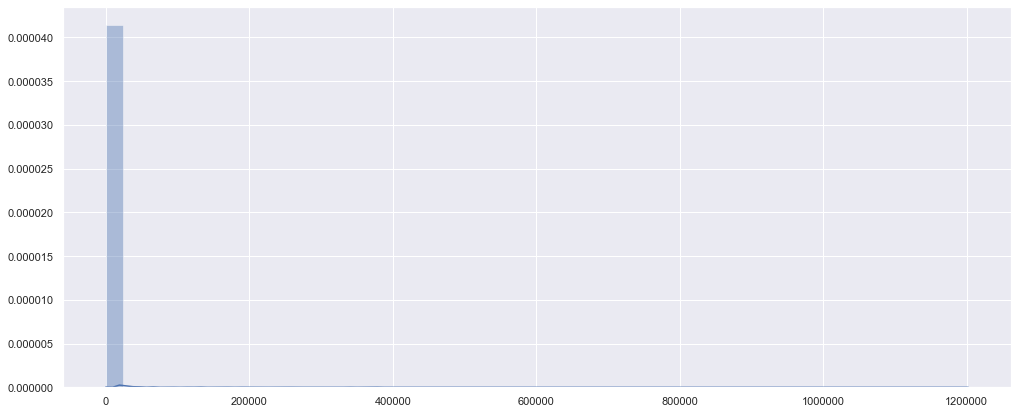

In [5]:
# set default plot size
sns.set(rc={'figure.figsize' : (17,7)})

# first check on the distribution shape looking for outliers
p = sns.distplot(total_assets_by_cand.VR_BEM_CANDIDATO.values / 1000) 

In [6]:
# divide vaules by 1000 to get data representation in thousands
asset_values = total_assets_by_cand['VR_BEM_CANDIDATO'].values / 1000

# obtain mean and std of the population and filter the dataset until 1 sd - it should cover ~ 68% of the dataset
mu = np.median(asset_values)
sd = np.std(asset_values)
fd = [e for e in asset_values if (mu - 1.0 * sd < e < mu + 1.0 * sd)]

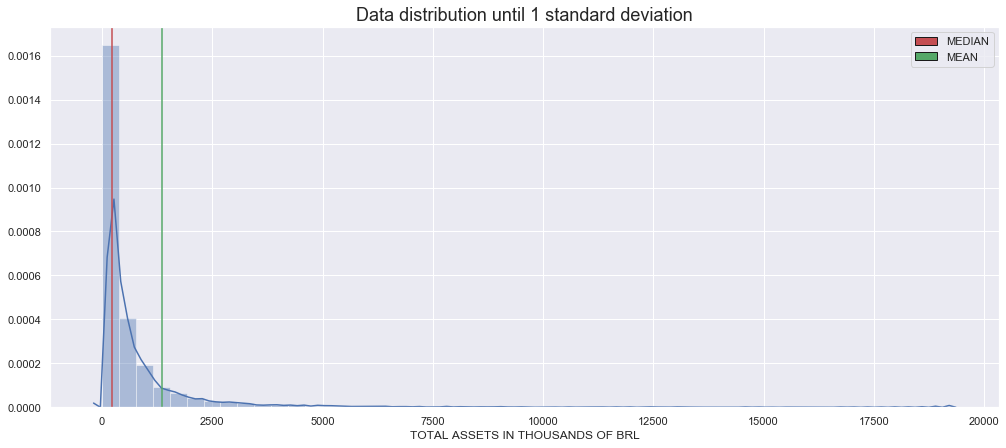

In [7]:
# plot figure
p = sns.distplot(fd) 

# add vertical lines to highlight mean and median
plt.axvline(np.median(asset_values), color='r')
plt.axvline(np.mean(asset_values), color='g')

# create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['r','g']]
labels= ["MEDIAN", "MEAN"]
plt.legend(handles, labels)
plt.title('Data distribution until 1 standard deviation', 
          fontdict={'fontsize': 18})
p.set_xlabel('TOTAL ASSETS IN THOUSANDS OF BRL')
plt.show()

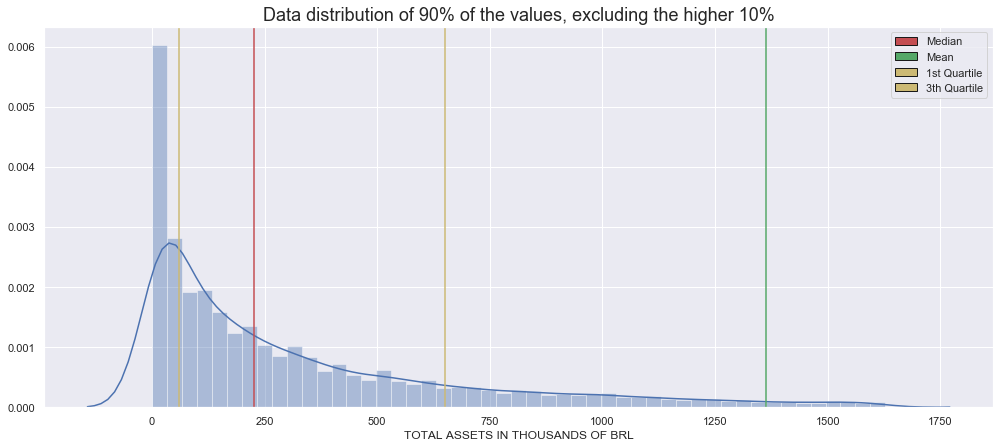

In [8]:
# plot figure
asset_values = total_assets_by_cand['VR_BEM_CANDIDATO'] / 1000
fd = asset_values[asset_values < asset_values.quantile(0.9)]
p = sns.distplot(fd) 

# add vertical lines to highlight mean and median
plt.axvline(np.median(asset_values), color='r')
plt.axvline(np.mean(asset_values), color='g')
plt.axvline(np.mean(asset_values.quantile(0.25)), color='y')
plt.axvline(np.mean(asset_values.quantile(0.75)), color='y')

# create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['r','g', 'y', 'y']]
labels= ["Median", "Mean", "1st Quartile", "3th Quartile"]
plt.legend(handles, labels)
plt.title('Data distribution of 90% of the values, excluding the higher 10%', 
          fontdict={'fontsize': 18})
p.set_xlabel('TOTAL ASSETS IN THOUSANDS OF BRL')
plt.show()

There is a lot of concentration of net value until the 2nd Quartile / Median.
Removing the higher 10% of the dataset gave a clear and better view on how the 
data is distributed and how the outliers push the mean far from the median

In [66]:
# Filter top 15 wealthy candidates
top_15 = total_assets_by_cand.head(15).sort_index().reset_index()
top_15['VR_BEM_CANDIDATO'] = top_15['VR_BEM_CANDIDATO'] / 1000000
aux = cand[['SQ_CANDIDATO', 'NM_CANDIDATO', 'DS_SIT_TOT_TURNO', 'DS_GENERO']]
aux.DS_GENERO.replace({'MASCULINO': 'MALE', 'FEMININO': 'FEMALE'}, inplace=True)
aux.set_index('SQ_CANDIDATO', inplace=True)
aux.loc[ : , 'STATUS'] = aux['DS_SIT_TOT_TURNO'].apply(lambda x: 'ELECTED' if x in ('ELEITO POR QP', 'ELEITO', 'ELEITO POR MÉDIA') else 'NOT ELECTED')
cand_names = aux.to_dict()['NM_CANDIDATO']
cand_status = aux.to_dict()['STATUS']
top_15['NAME'] = top_15['SQ_CANDIDATO'].apply(lambda x: cand_names.get(x))
top_15['STATUS'] = top_15['SQ_CANDIDATO'].apply(lambda x: cand_status.get(x))
#ax = sns.barplot(x="SQ_CANDIDATO", y="VR_BEM_CANDIDATO", data=total_assets_by_cand.head(10).sort_index().reset_index())

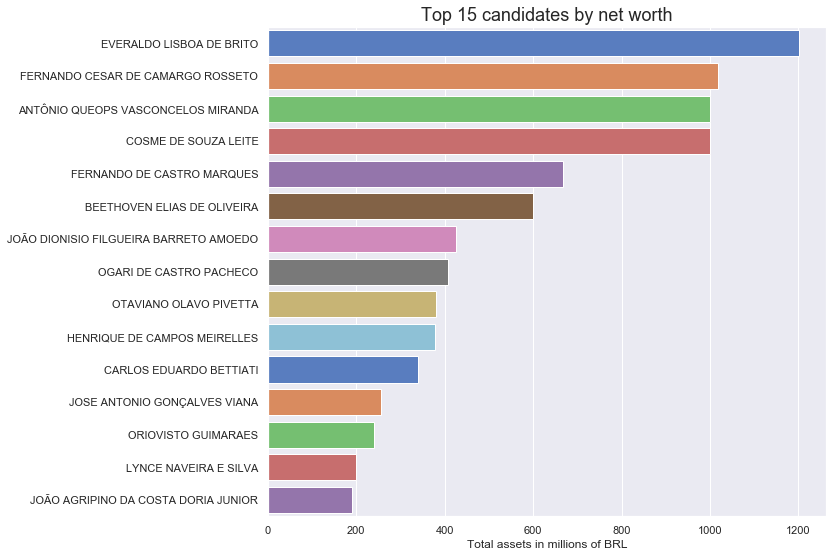

In [10]:
sns.set(rc={'figure.figsize' : (10,9)})
top_15.sort_values('VR_BEM_CANDIDATO', ascending=False, inplace=True)
g = sns.barplot(data=top_15, y='NAME', x='VR_BEM_CANDIDATO', palette='muted')
g.set_ylabel('')
g.set_xlabel('Total assets in millions of BRL')
plt.title('Top 15 candidates by net worth', 
          fontdict={'fontsize': 18})
plt.show()

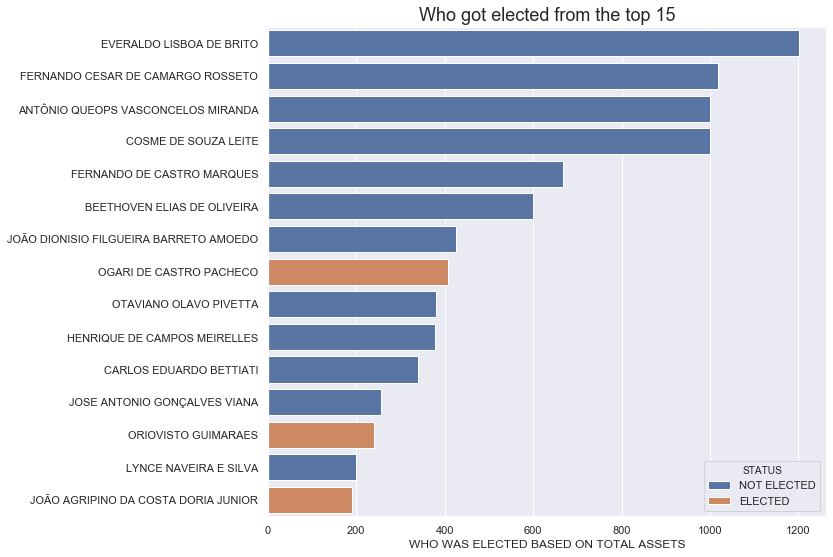

In [11]:
g = sns.barplot(x='VR_BEM_CANDIDATO', y='NAME', hue='STATUS', data=top_15, dodge=False)
g.set_ylabel('')
g.set_xlabel('Who was elected based on total assets'.upper())
plt.title('Who got elected from the top 15', 
          fontdict={'fontsize': 18})
plt.show()

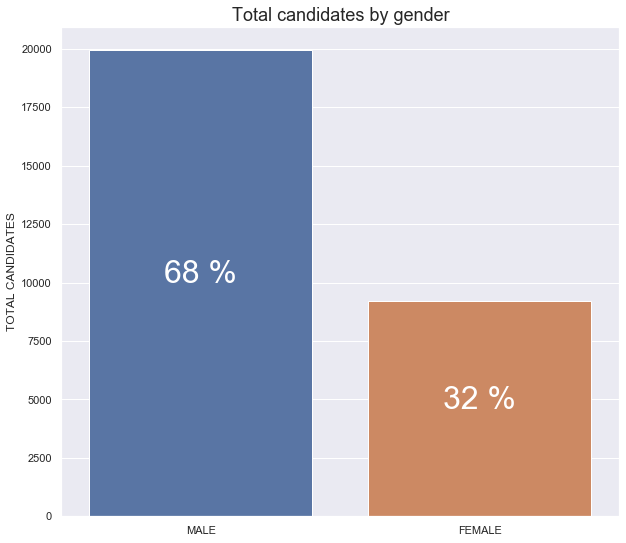

In [60]:
cand.DS_GENERO.replace({'MASCULINO': 'MALE', 'FEMININO': 'FEMALE'}, inplace=True)
gender = cand.DS_GENERO.value_counts().reset_index()
gend_perc = (cand.DS_GENERO.value_counts(normalize=True) * 100).to_dict()

g = sns.barplot(x='index', y='DS_GENERO', data=gender)
g.set_ylabel('Total candidates'.upper())
g.set_xlabel('')

for i, r in gender.iterrows():
    g.text(r.name, 
           r['DS_GENERO'] / 2, 
           '{:.0f} %'.format(gend_perc[r['index']]), 
           ha='center', 
           fontdict={'fontsize':32, 'family':'sans-serif'},
           color='white')
plt.title('Total candidates by gender', 
          fontdict={'fontsize': 18})
plt.show()

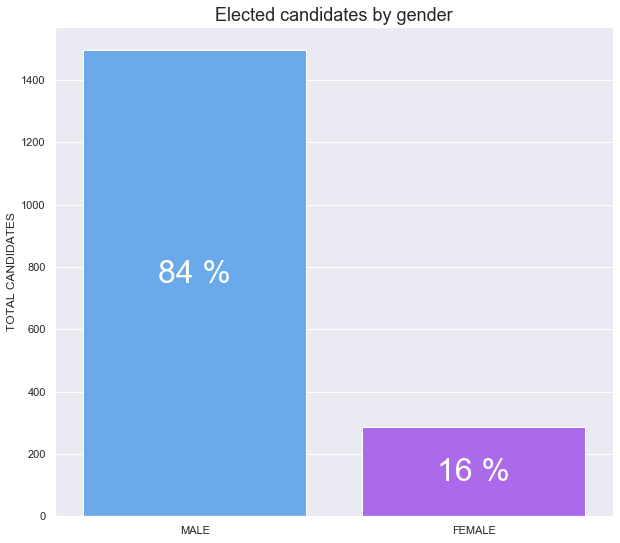

In [13]:
gend_perc = (aux[aux['STATUS'] == 'ELECTED'].DS_GENERO.value_counts(normalize=True) * 100).to_dict()
gender_elected = aux[aux['STATUS'] == 'ELECTED'].DS_GENERO.value_counts().reset_index()
g = sns.barplot(x='index', y='DS_GENERO', data=gender_elected, palette='cool')
g.set_ylabel('Total candidates'.upper())
g.set_xlabel('')
plt.title('Elected candidates by gender', 
          fontdict={'fontsize': 18})

for i, r in gender_elected.iterrows():
    g.text(r.name, 
           (r['DS_GENERO'] / 2) * { 0 : 1, 1 : 0.8 }.get(r.name), 
           '{:.0f} %'.format(gend_perc[r['index']]), 
           ha='center', 
           fontdict={'fontsize':32, 'family':'sans-serif'},
           color='white')
plt.show()

In [97]:
assets_dict =  total_assets_by_cand.to_dict()['VR_BEM_CANDIDATO']
aux.loc[ : , 'NET_WORTH'] = aux.index.map(lambda x: assets_dict.get(x)) / 10**6

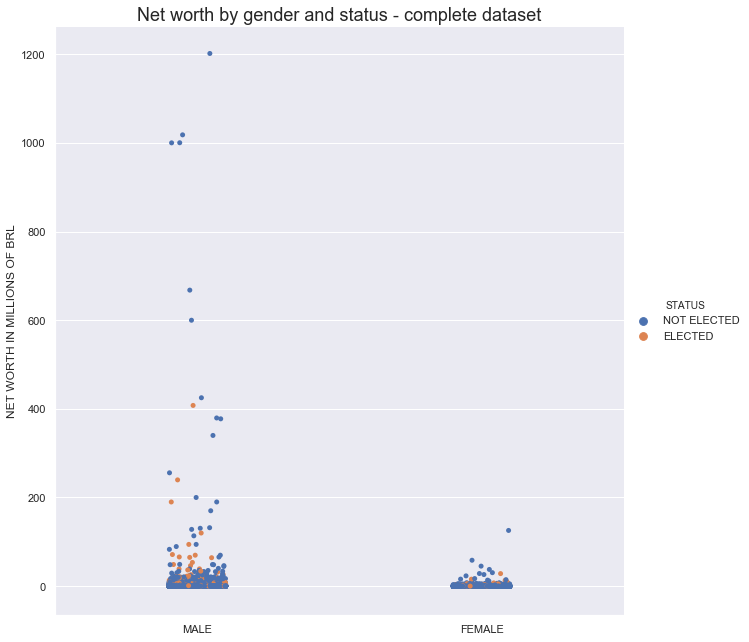

In [57]:
gender_assets = aux.iloc[ : , -3:].fillna(0)
g = sns.catplot(x='DS_GENERO', y='NET_WORTH', hue='STATUS', data=gender_assets, height=9, aspect=1)
_ = g.set_axis_labels('', 'Net worth in millions of BRL'.upper())
plt.title('Net worth by gender and status - complete dataset', 
          fontdict={'fontsize': 18})
plt.show()

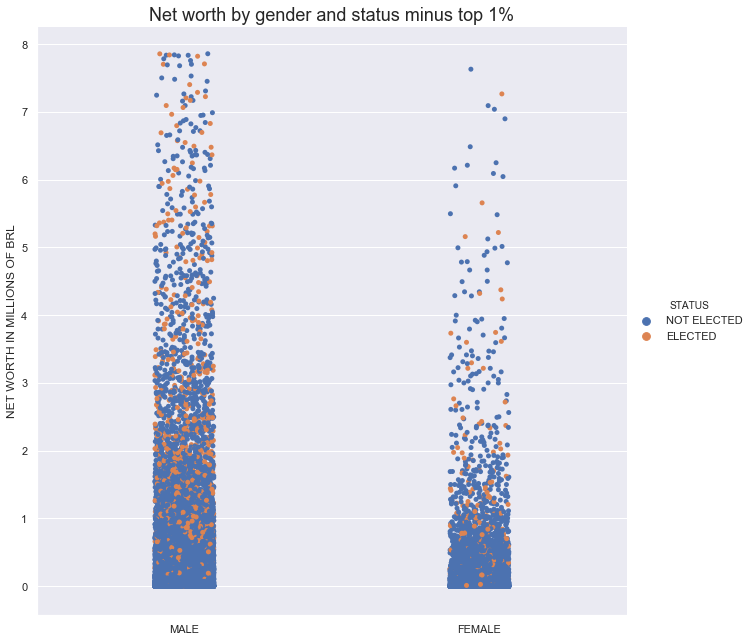

In [59]:
g = sns.catplot(x='DS_GENERO', y='NET_WORTH', hue='STATUS', data=gender_assets[gender_assets.NET_WORTH < gender_assets.NET_WORTH.quantile(0.99)], height=9, aspect=1)
_ = g.set_axis_labels('', 'Net worth in millions of BRL'.upper())
plt.title('Net worth by gender and status minus top 1%', 
          fontdict={'fontsize': 18})
plt.show()

In [78]:
age_dict = dict(cand[['SQ_CANDIDATO', 'NR_IDADE_DATA_POSSE']].to_dict('split')['data'])
aux.loc[ : , 'AGE'] = aux.index.map(lambda x: age_dict.get(x))

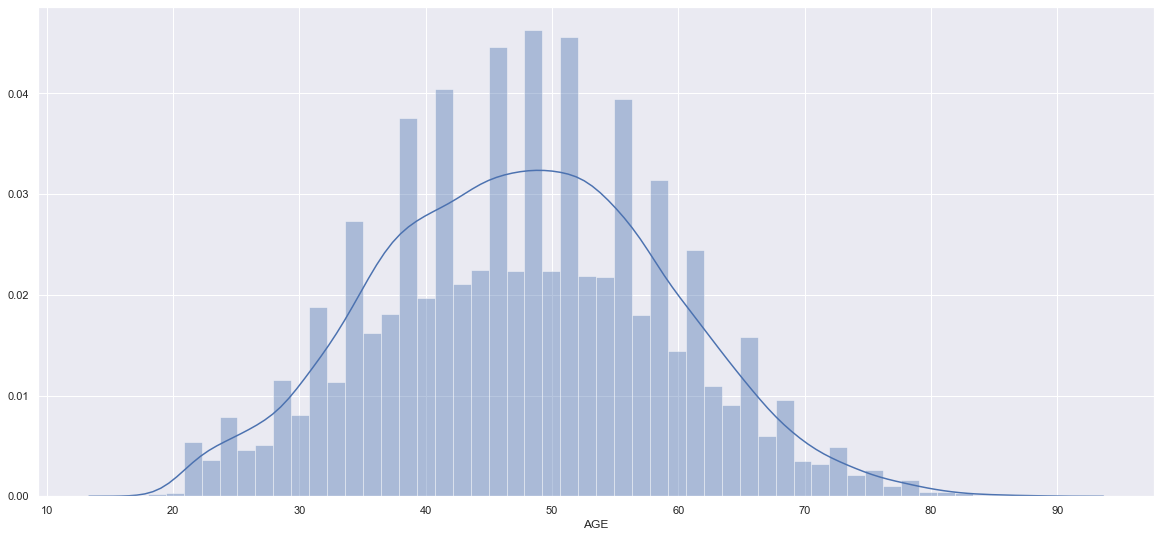

In [93]:
sns.set(rc={'figure.figsize' : (20,9)})
sns.distplot(aux.AGE[aux.AGE < 90])

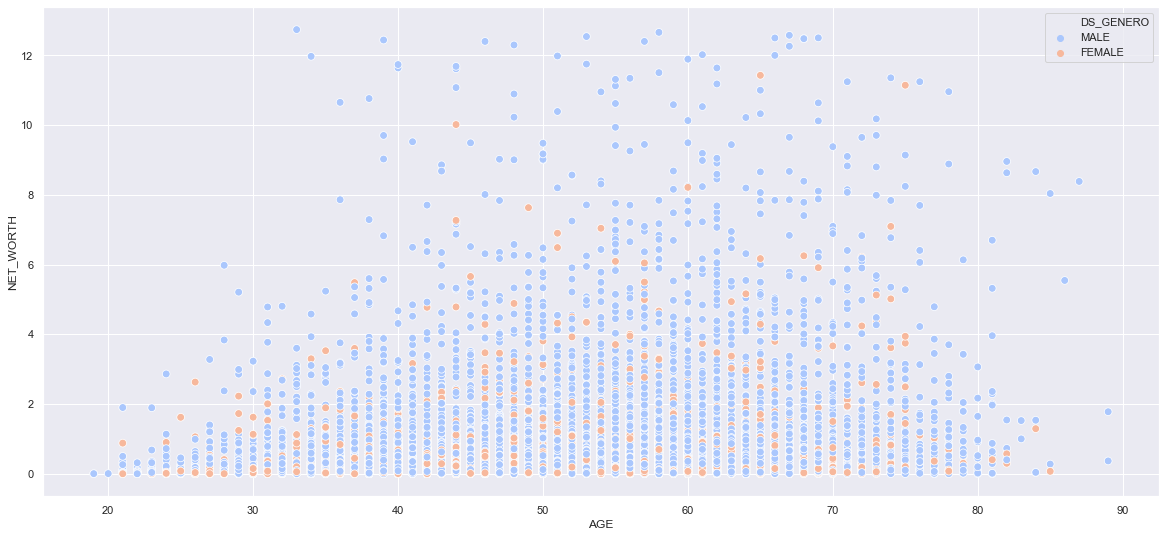

In [122]:
g = sns.scatterplot(x='AGE', y='NET_WORTH', hue='DS_GENERO', data=aux[aux.NET_WORTH < aux.NET_WORTH.quantile(0.99)], palette='coolwarm', s=60)

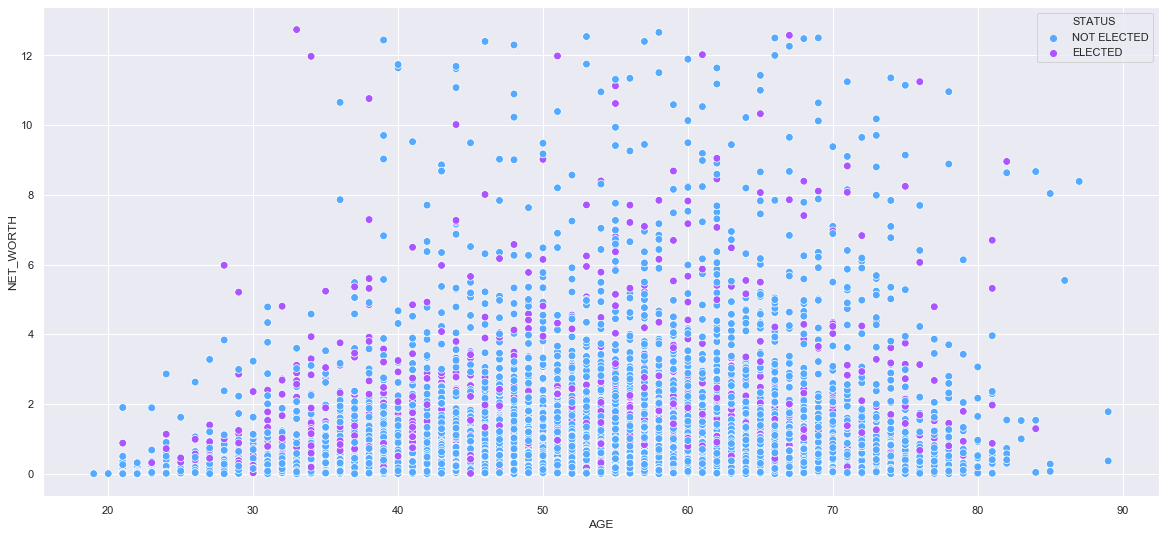

In [123]:
g = sns.scatterplot(x='AGE', y='NET_WORTH', hue='STATUS', data=aux[aux.NET_WORTH < aux.NET_WORTH.quantile(0.99)], palette='cool', s=60)